In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Conv1D,MaxPooling1D,Add,GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from pathlib import Path
import shutil, os
import glob
from sklearn.model_selection import train_test_split
tweet_path='./data/preprocessed_tweet.csv'
train_path = './data/train.csv'
test_path = './data/test.csv'

In [ ]:
# df=pd.read_csv(tweet_path)
# df = df.dropna()
# df_training ,df_testing = train_test_split(df,test_size = 0.1,random_state = 1)

In [ ]:
# df_training = df_training.reset_index(drop=True)
# df_testing = df_testing.reset_index(drop=True)

In [ ]:
# df_training.to_csv(train_path,index = False)
# df_testing.to_csv(test_path,index = False)
%store training_data

Stored 'training_data' (DataFrame)


In [ ]:
training_data = pd.read_csv(train_path)
testing_data = pd.read_csv(test_path)

In [ ]:
testing_data.head()

,text,label
0,RT “It is not humanly possible to engage kids ...,positive
1,Holy fuk that is a lot,redundant
2,ALSO RHEA CALLING RHEA WHERE IS you,negative
3,ganja gang skz are our leaderspleading_face,negative
4,only if they knew it was in response to the ti...,redundant


In [ ]:
training_data.head()

,text,label
0,Absolute nonsence pouting_facepouting_facepout...,positive
1,Arnab on pulwama?,redundant
2,Look at that nothing shot by Archer. And these...,negative
3,tankies are the best chup lodu. send vns,negative
4,RT See full pic partying_face,positive


In [ ]:
hate,non_hate = training_data[training_data['label'] == 'negative' ].reset_index(drop=True) ,training_data[training_data['label'] != 'negative' ].reset_index(drop=True)

## Conversion to embeddings

In [ ]:
vocab_size = 1024
sent_length=1024

In [ ]:
hate['one_hot'] = hate.apply(lambda row:one_hot(row.text  ,vocab_size) , axis = 1)
non_hate['one_hot'] = non_hate.apply(lambda row:one_hot(row.text  ,vocab_size) , axis = 1)
hate['one_hot']=list(pad_sequences(hate['one_hot'],padding='pre',maxlen=sent_length))
non_hate['one_hot']=list(pad_sequences(non_hate['one_hot'],padding='pre',maxlen=sent_length))

## Splitting Data and conversion to tensors

In [ ]:
def my_func(arg):
  arg = tf.convert_to_tensor(arg, dtype=tf.float32)
  return arg

In [ ]:
non_hate_val,non_hate_train = my_func(list(non_hate['one_hot'][:3000])) , my_func(list(non_hate['one_hot'][3000:]))

## Testing different small models

In [ ]:
def generateModel(small_model,n):
    '''
    Utility function to generate a sample model for testing seprate network
    Input :- Fuction to generate seprate small network
    Output:- Sample model to test the data
    '''
    input_layer = keras.Input(shape=(None,),name="Input_Sentence")
    input_embeddings = layers.Embedding(vocab_size,64)(input_layer)
    x = small_model(input_embeddings)
    
#     x = layers.Dense(64, activation="relu")(x)
#     x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
#     x = layers.Dense(512, activation="relu")(x)
    outputs = layers.Dense(1024, activation="relu")(x)
    
    model = keras.Model(input_layer, outputs, name=n)
    model.compile(optimizer='adam',loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    return model

In [ ]:
def trainModel(model,name):
    Path('./models/'+name).mkdir(parents=True, exist_ok=True)
    filepath= "./models/" +name+ '/checkpoint' + "_epoch-{epoch:2d}_rms-{root_mean_squared_error:.2f}.h5"
    checkP = glob.glob('./models/'+name+"/*.h5")
    if(len(checkP)>0):
        model.load_weights(checkP[0])
    checkpoint = ModelCheckpoint(filepath, save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )
    callbacks_list = [checkpoint]
    history = model.fit(non_hate_train,non_hate_train, validation_split=0.2,epochs=15,callbacks=callbacks_list)
    return model,history

## Mini-Googl-Net

In [ ]:
def inseptionNetwork(input_embeddings):
    '''
    2-layer inseption network generator function
    Input : Model till input embedding layer
    Output: Generated model till inseption network
    '''
    x1f = layers.Conv1D(64, 1, activation="relu", padding = "same")(input_embeddings)
    x2f = layers.Conv1D(64, 2, activation="relu", padding = "same")(input_embeddings)
    x3f = layers.Conv1D(64, 3, activation="relu", padding = "same")(input_embeddings)
    x4f = layers.Conv1D(64, 4, activation="relu", padding = "same")(input_embeddings)
    x5f = layers.Conv1D(64, 5, activation="relu", padding = "same")(input_embeddings)
    
    y = layers.concatenate([x1f,x2f,x3f,x4f,x5f])
    x1f = layers.Conv1D(64, 1, activation="relu", padding = "same")(y)
    x2f = layers.Conv1D(64, 2, activation="relu", padding = "same")(y)
    x3f = layers.Conv1D(64, 3, activation="relu", padding = "same")(y)
    x4f = layers.Conv1D(64, 4, activation="relu", padding = "same")(y)
    x5f = layers.Conv1D(64, 5, activation="relu", padding = "same")(y)
    y = layers.concatenate([x1f,x2f,x3f,x4f,x5f])
    
    y = layers.GlobalMaxPooling1D()(y)
    return y

In [ ]:
mini_google_model = generateModel(inseptionNetwork,'mini-google-net')

Model: "mini-google-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Sentence (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     65536       Input_Sentence[0][0]             
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, None, 64)     4160        embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, None, 64)     8256        embedding_2[0][0]                
____________________________________________________________________________________

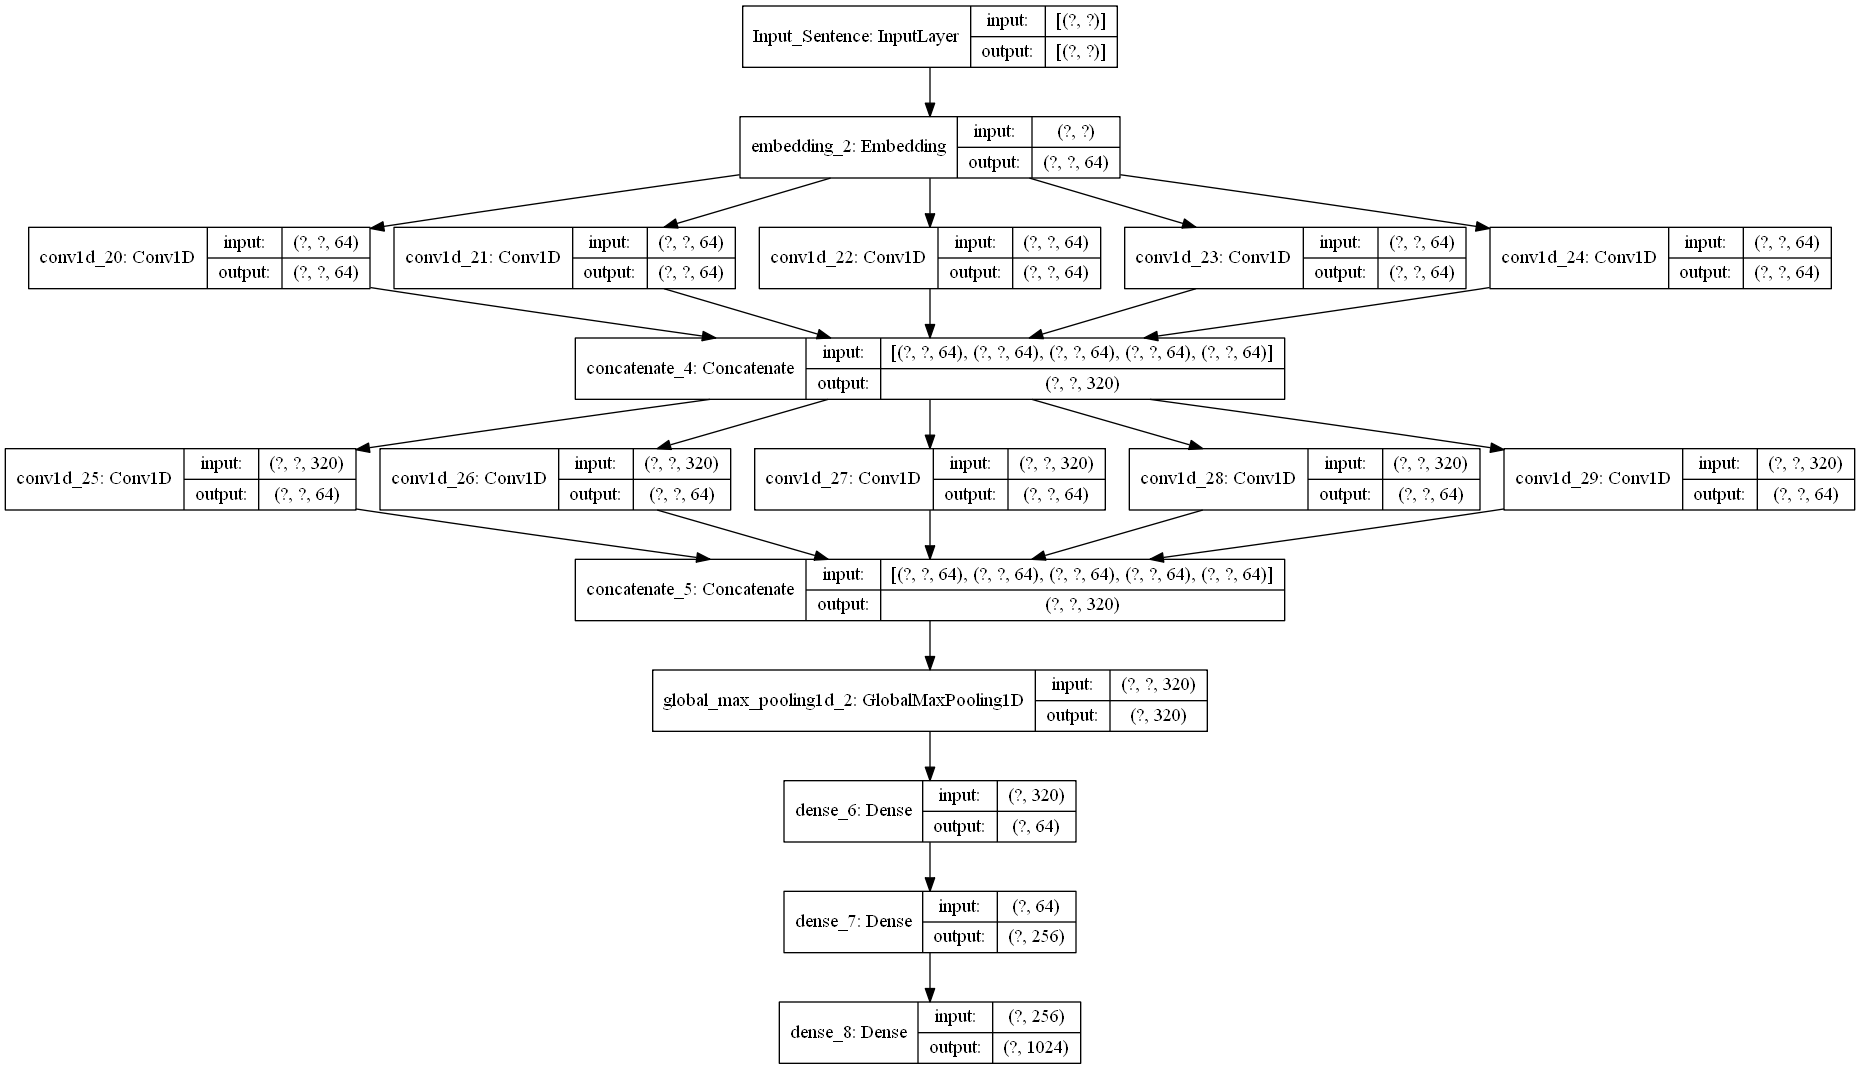

In [ ]:
keras.utils.plot_model(mini_google_model,show_shapes= True,to_file="./model-image/mini-google-net.png")

In [ ]:
mini_google_model ,history_mg = trainModel(mini_google_model,'mini-google-model')

Epoch 1/15
 52/258 [=====>........................] - ETA: 4:13 - loss: 2975.2395 - root_mean_squared_error: 54.5458

KeyboardInterrupt: 

## Google-net multiple layer

In [ ]:
def inseptionNetwork2Layer(input_embeddings):
    '''
    2-layer inseption network generator function
    Input : Model till input embedding layer
    Output: Generated model till inseption network
    '''
    
    x1f = layers.Conv1D(8, 1, activation="relu", padding = "same")(input_embeddings)
    x2f = layers.Conv1D(16, 2, activation="relu", padding = "same")(input_embeddings)
    x3f = layers.Conv1D(32, 3, activation="relu", padding = "same")(input_embeddings)
    x4f = layers.Conv1D(64, 4, activation="relu", padding = "same")(input_embeddings)
    x5f = layers.Conv1D(64, 5, activation="relu", padding = "same")(input_embeddings)
    
    y = layers.concatenate([x1f,x2f,x3f,x4f,x5f])
    x1f = layers.Conv1D(8, 1, activation="relu", padding = "same")(y)
    x2f = layers.Conv1D(16, 2, activation="relu", padding = "same")(y)
    x3f = layers.Conv1D(32, 3, activation="relu", padding = "same")(y)
    x4f = layers.Conv1D(64, 4, activation="relu", padding = "same")(y)
    x5f = layers.Conv1D(64, 5, activation="relu", padding = "same")(y)
    y = layers.concatenate([x1f,x2f,x3f,x4f,x5f])
    
    y = layers.MaxPooling1D()(y)
    
    x1f = layers.Conv1D(8, 1, activation="relu", padding = "same")(y)
    x2f = layers.Conv1D(16, 2, activation="relu", padding = "same")(y)
    x3f = layers.Conv1D(32, 3, activation="relu", padding = "same")(y)
    x4f = layers.Conv1D(64, 4, activation="relu", padding = "same")(y)
    x5f = layers.Conv1D(64, 5, activation="relu", padding = "same")(y)
    y = layers.concatenate([x1f,x2f,x3f,x4f,x5f])

    x1f = layers.Conv1D(8, 1, activation="relu", padding = "same")(y)
    x2f = layers.Conv1D(16, 2, activation="relu", padding = "same")(y)
    x3f = layers.Conv1D(32, 3, activation="relu", padding = "same")(y)
    x4f = layers.Conv1D(64, 4, activation="relu", padding = "same")(y)
    x5f = layers.Conv1D(64, 5, activation="relu", padding = "same")(y)
    y = layers.concatenate([x1f,x2f,x3f,x4f,x5f])
    
    y = layers.GlobalMaxPooling1D()(y)
    
    return y

In [ ]:
mini_google_model_2 = generateModel(inseptionNetwork2Layer,'mini-google-model-2')

Model: "mini-google-model-2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Sentence (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 64)     65536       Input_Sentence[0][0]             
__________________________________________________________________________________________________
conv1d_50 (Conv1D)              (None, None, 8)      520         embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, None, 16)     2064        embedding_4[0][0]                
________________________________________________________________________________

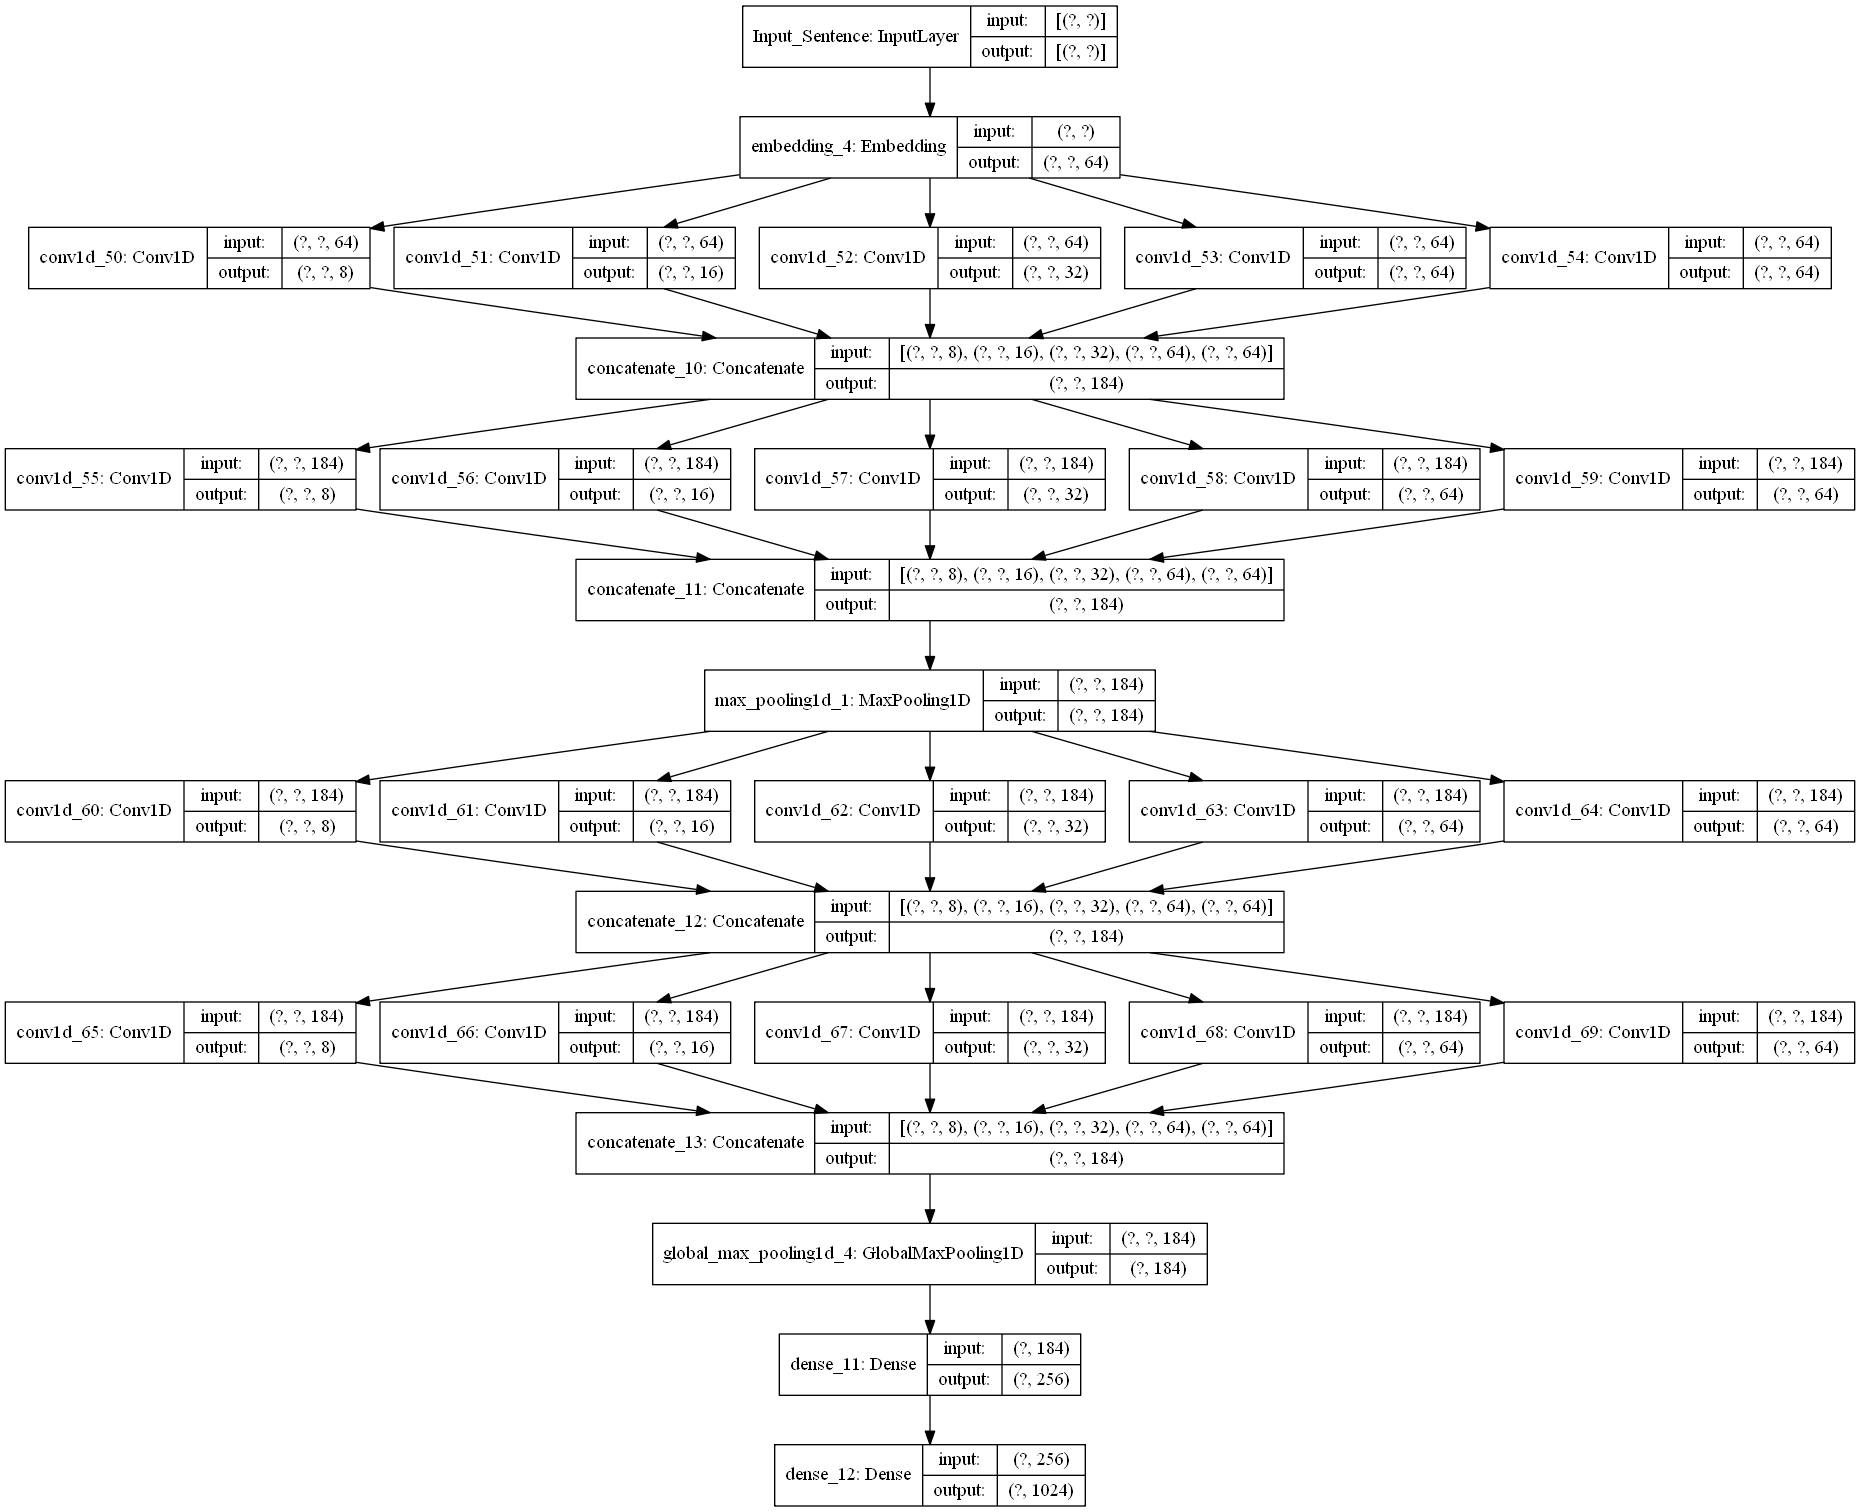

In [ ]:
keras.utils.plot_model(mini_google_model_2,show_shapes= True,to_file="./model-image/mini-google-net-2-layer.png")

In [ ]:
mini_google_model_2 ,history_mg_2 = trainModel(mini_google_model_2,'mini-google-model-2')

Epoch 1/15
258/258 [==============================] - 358s 1s/step - loss: 3279.0261 - root_mean_squared_error: 57.2628 - val_loss: 2930.0537 - val_root_mean_squared_error: 54.1300
Epoch 2/15
258/258 [==============================] - 359s 1s/step - loss: 2482.8362 - root_mean_squared_error: 49.8281 - val_loss: 2001.5520 - val_root_mean_squared_error: 44.7387
Epoch 3/15
258/258 [==============================] - 365s 1s/step - loss: 1900.9944 - root_mean_squared_error: 43.6004 - val_loss: 1841.5209 - val_root_mean_squared_error: 42.9129
Epoch 4/15
258/258 [==============================] - 361s 1s/step - loss: 1764.9413 - root_mean_squared_error: 42.0112 - val_loss: 1732.4646 - val_root_mean_squared_error: 41.6229
Epoch 5/15
258/258 [==============================] - 370s 1s/step - loss: 1670.2828 - root_mean_squared_error: 40.8691 - val_loss: 1669.2644 - val_root_mean_squared_error: 40.8566
Epoch 6/15
258/258 [==============================] - ETA: 0s - loss: 1579.5132 - root_mean_squ

KeyboardInterrupt: 

## Mini-Resnet

In [1]:
def resNet(input_embedding):
    x = layers.Conv1D(32, 3, activation="relu")(input_embedding)
    x = layers.Conv1D(64, 3, activation="relu")(x)
    block_1_output = layers.MaxPooling1D(3)(x)

    x = layers.Conv1D(32, 3, activation="relu", padding="same")(block_1_output)
    x = layers.Conv1D(64, 3, activation="relu", padding="same")(x)
    block_2_output = layers.add([x, block_1_output])

    x = layers.Conv1D(32, 3, activation="relu", padding="same")(block_2_output)
    x = layers.Conv1D(64, 3, activation="relu", padding="same")(x)
    block_3_output = layers.add([x, block_2_output])

    x = layers.Conv1D(64, 3, activation="relu")(block_3_output)
    x = layers.GlobalMaxPooling1D()(x)
    return x

In [2]:
mini_residual_model = generateModel(resNet)

NameError: ignored

In [ ]:
keras.utils.plot_model(mini_residual_model,show_shapes= True,to_file="./model-image/mini-residual-net.png")

In [ ]:
mini_residual_model ,history_mr = trainModel(mini_residual_model,'mini-residual-model')

## LSTM

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def LSTMnetwork(input_embeddings):
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(input_embeddings)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    
    return x

In [ ]:
LSTM_model = generateModel(LSTMnetwork)

Model: "mini-google-net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Sentence (InputLayer)  [(None, None)]            0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 512)         657408    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         656384    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         164352    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_10 (Dense)             (None, 256)           

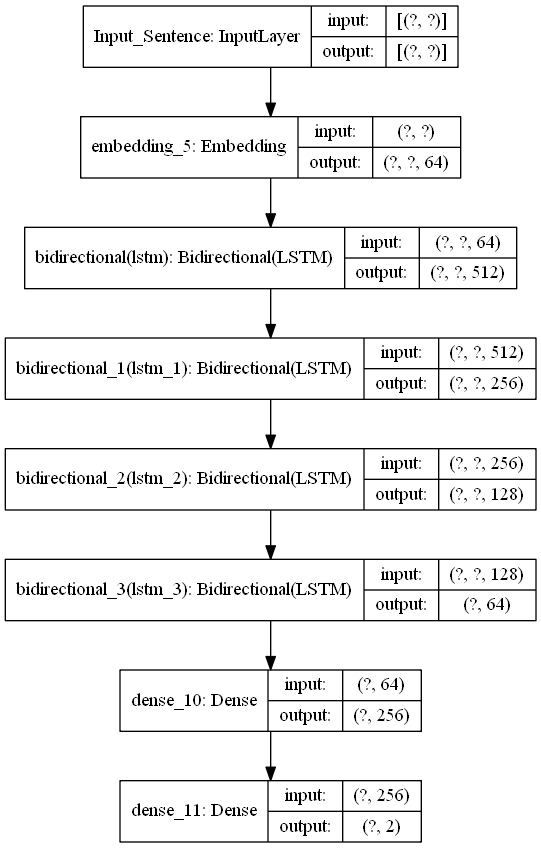

In [ ]:
keras.utils.plot_model(LSTM_model,show_shapes= True,to_file="./model-image/lstm-network.png")

In [ ]:
LSTM_model,history_lstm = trainModel(LSTM_model,'lstm-model')

Epoch 1/15
32/32 [==============================] - 1496s 47s/step - loss: 0.8191 - accuracy: 0.5470 - val_loss: 0.6741 - val_accuracy: 0.6700
Epoch 2/15
32/32 [==============================] - 1556s 49s/step - loss: 0.5942 - accuracy: 0.6870 - val_loss: 0.5215 - val_accuracy: 0.8800
Epoch 3/15
32/32 [==============================] - 1691s 53s/step - loss: 4.2194 - accuracy: 0.8630 - val_loss: 4.3379 - val_accuracy: 0.3900
Epoch 4/15
32/32 [==============================] - 1772s 55s/step - loss: 3.5798 - accuracy: 0.4890 - val_loss: 1.3165 - val_accuracy: 0.8800
Epoch 5/15
32/32 [==============================] - 1796s 56s/step - loss: 1.1772 - accuracy: 0.9190 - val_loss: 4.2944 - val_accuracy: 0.7200
Epoch 6/15
32/32 [==============================] - 1795s 56s/step - loss: 3.7269 - accuracy: 0.7570 - val_loss: 4.4478 - val_accuracy: 0.7100
Epoch 7/15
32/32 [==============================] - 1538s 48s/step - loss: 3.8189 - accuracy: 0.7510 - val_loss: 4.4478 - val_accuracy: 0.7100

## Googlenet ,Resnet, LSTM

### V1

In [ ]:
def genall3v1(input_embeddings):
    gnet = inseptionNetwork(input_embeddings)
    resnet = resNet(input_embeddings)
    lstm = LSTMnetwork(input_embeddings)
    y = layers.concatenate([gnet,resnet,lstm])
    return y

In [ ]:
all3_v1_model = generateModel(genall3v1) 

Model: "mini-google-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Sentence (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 64)     64000       Input_Sentence[0][0]             
__________________________________________________________________________________________________
conv1d_77 (Conv1D)              (None, None, 32)     6176        embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_78 (Conv1D)              (None, None, 64)     6208        conv1d_77[0][0]                  
____________________________________________________________________________________

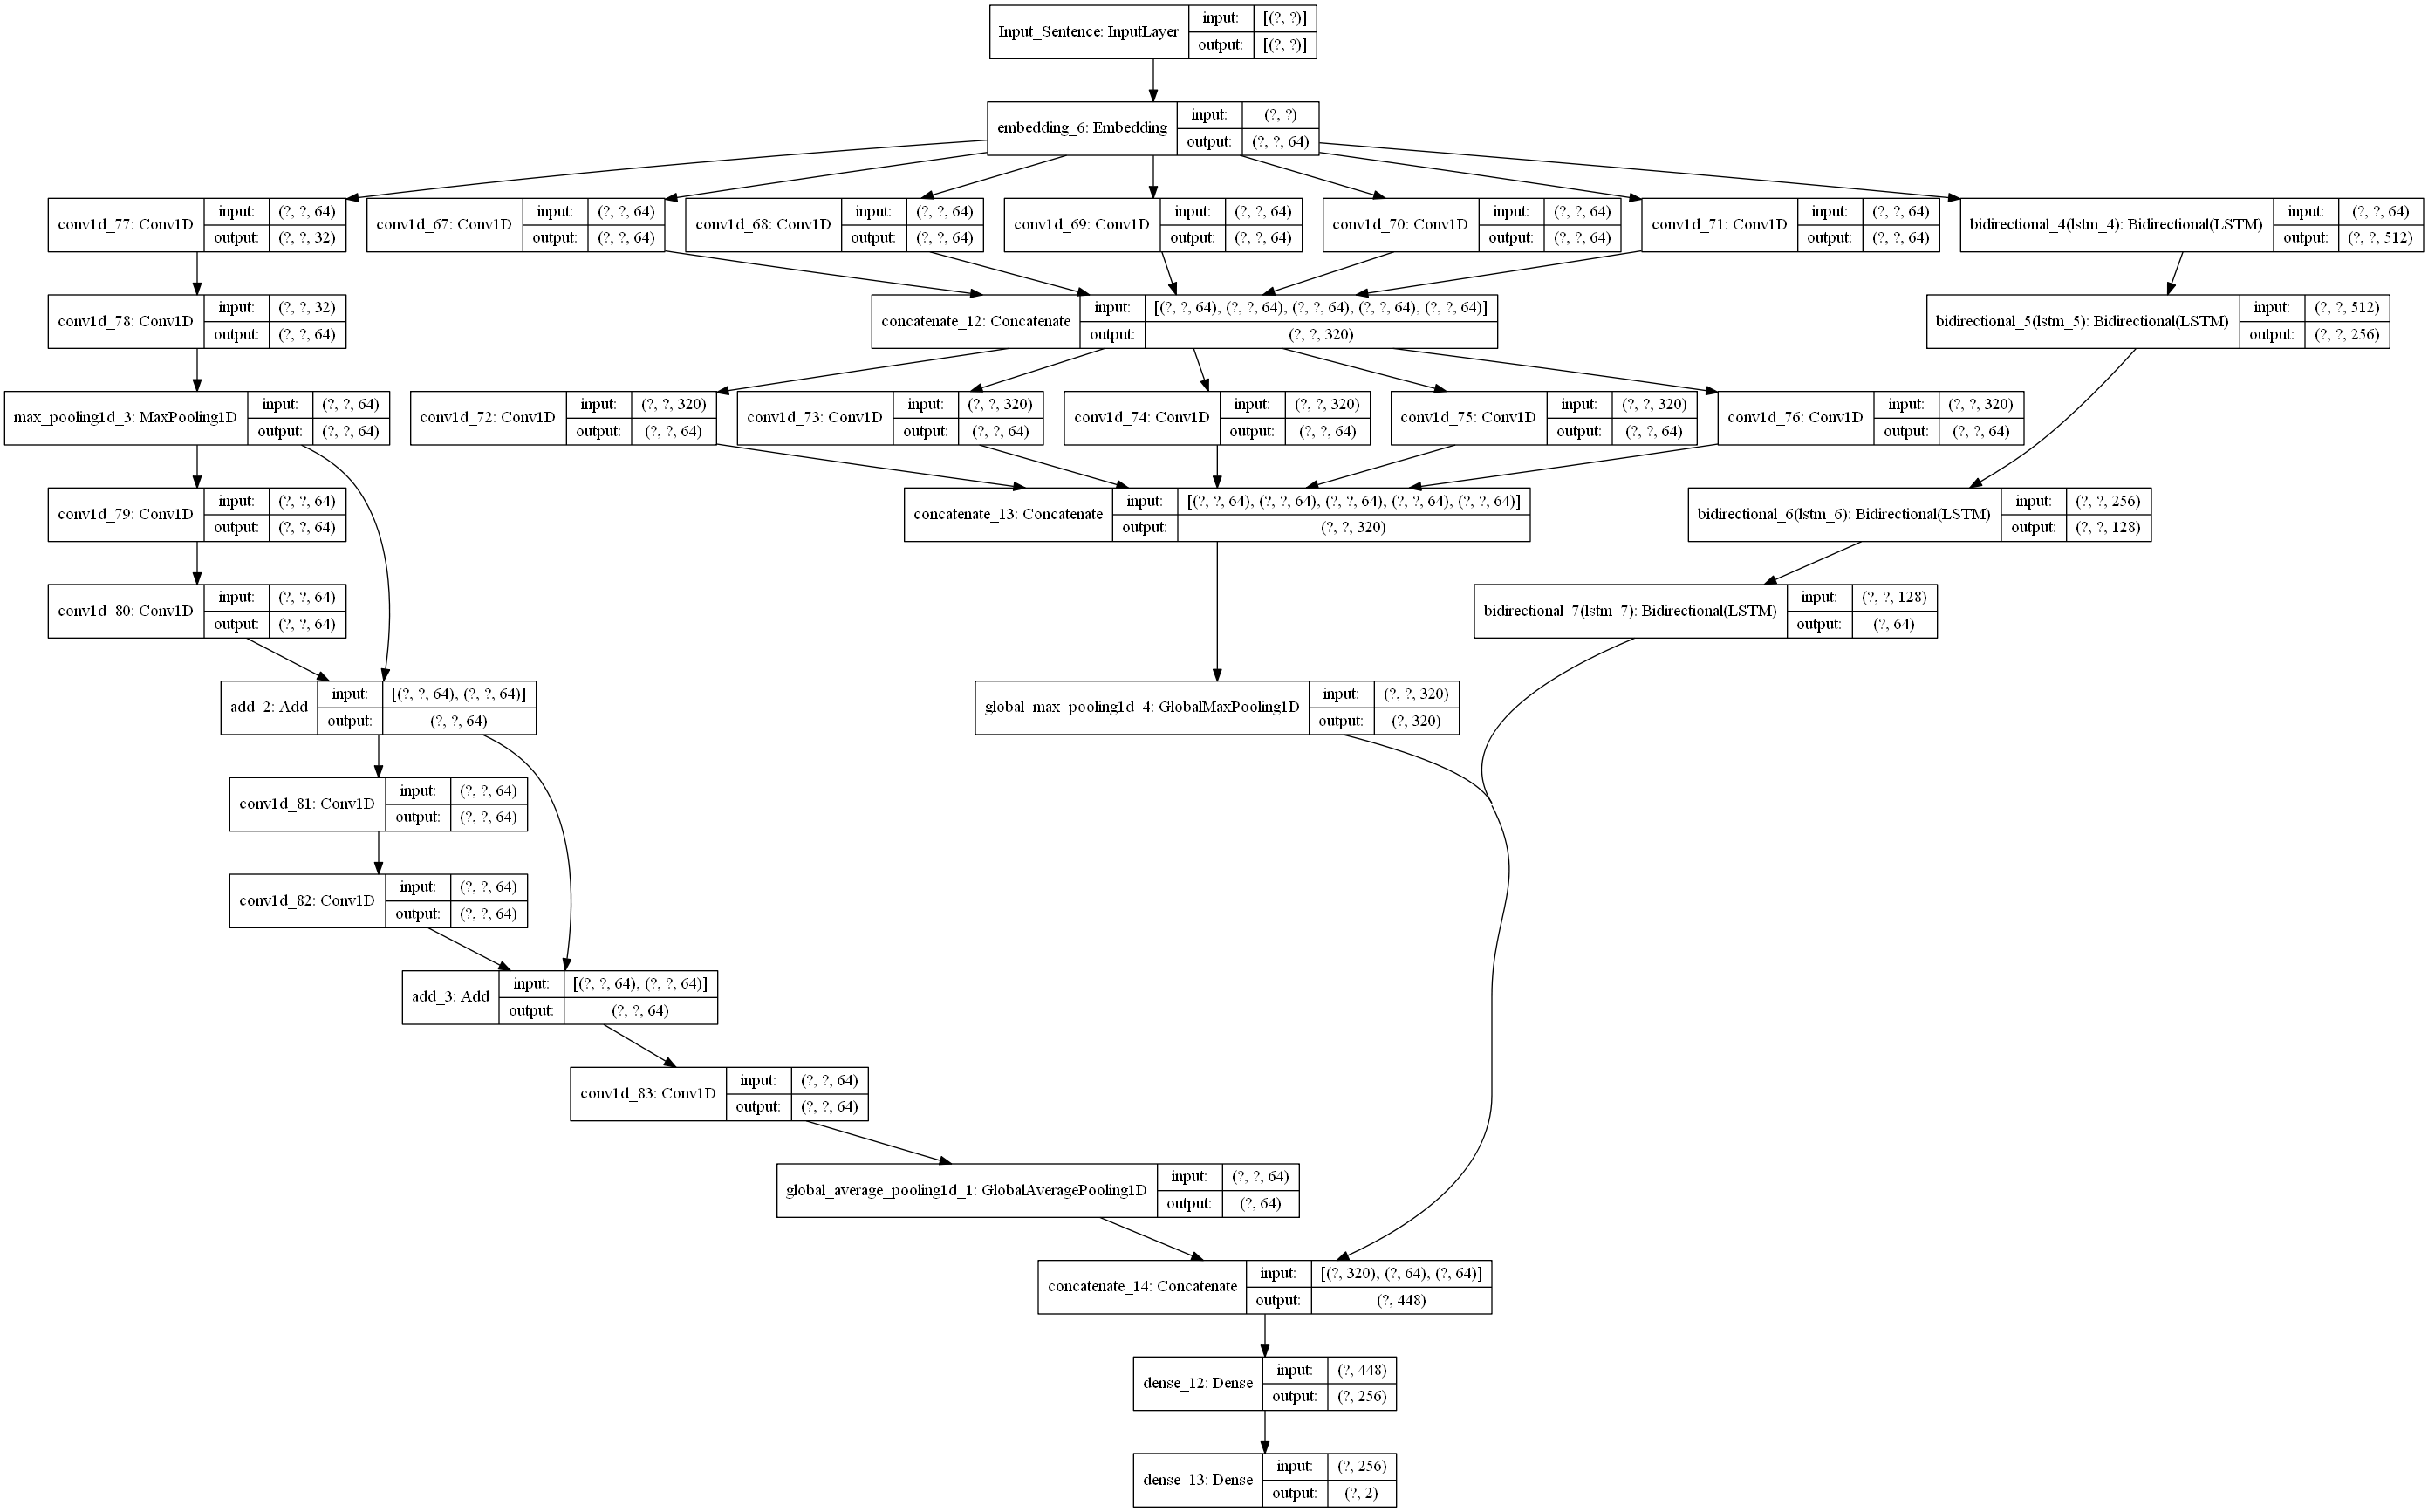

In [ ]:
keras.utils.plot_model(all3_v1_model,show_shapes= True,to_file="./model-image/all3-v1.png")

In [ ]:
all3_v1_model ,history_all3v1 = trainModel(all3_v1_model,'all3v1')

Epoch 1/15
32/32 [==============================] - 1870s 58s/step - loss: 0.7769 - accuracy: 0.5990 - val_loss: 0.4744 - val_accuracy: 0.8400
Epoch 2/15
32/32 [==============================] - 1903s 59s/step - loss: 0.5403 - accuracy: 0.7540 - val_loss: 0.4460 - val_accuracy: 0.5400
Epoch 3/15
32/32 [==============================] - 1896s 59s/step - loss: 0.2520 - accuracy: 0.8940 - val_loss: 0.3513 - val_accuracy: 0.9400
Epoch 4/15
32/32 [==============================] - 1986s 62s/step - loss: 0.1364 - accuracy: 0.9280 - val_loss: 0.2003 - val_accuracy: 0.9300
Epoch 5/15
10/32 [========>.....................] - ETA: 22:22 - loss: 0.0951 - accuracy: 0.9688

KeyboardInterrupt: 

### V2

In [ ]:
def genall3v2(input_embeddings):
    gnet = inseptionNetwork2Layer(input_embeddings)
    resnet = resNet(input_embeddings)
    lstm = LSTMnetwork(input_embeddings)
    y = layers.concatenate([gnet,resnet,lstm])
    return y

In [ ]:
all3_v2_model = generateModel(genall3v2)

Model: "mini-google-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Sentence (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 64)     64000       Input_Sentence[0][0]             
__________________________________________________________________________________________________
conv1d_104 (Conv1D)             (None, None, 32)     6176        embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_84 (Conv1D)              (None, None, 64)     4160        embedding_7[0][0]                
____________________________________________________________________________________

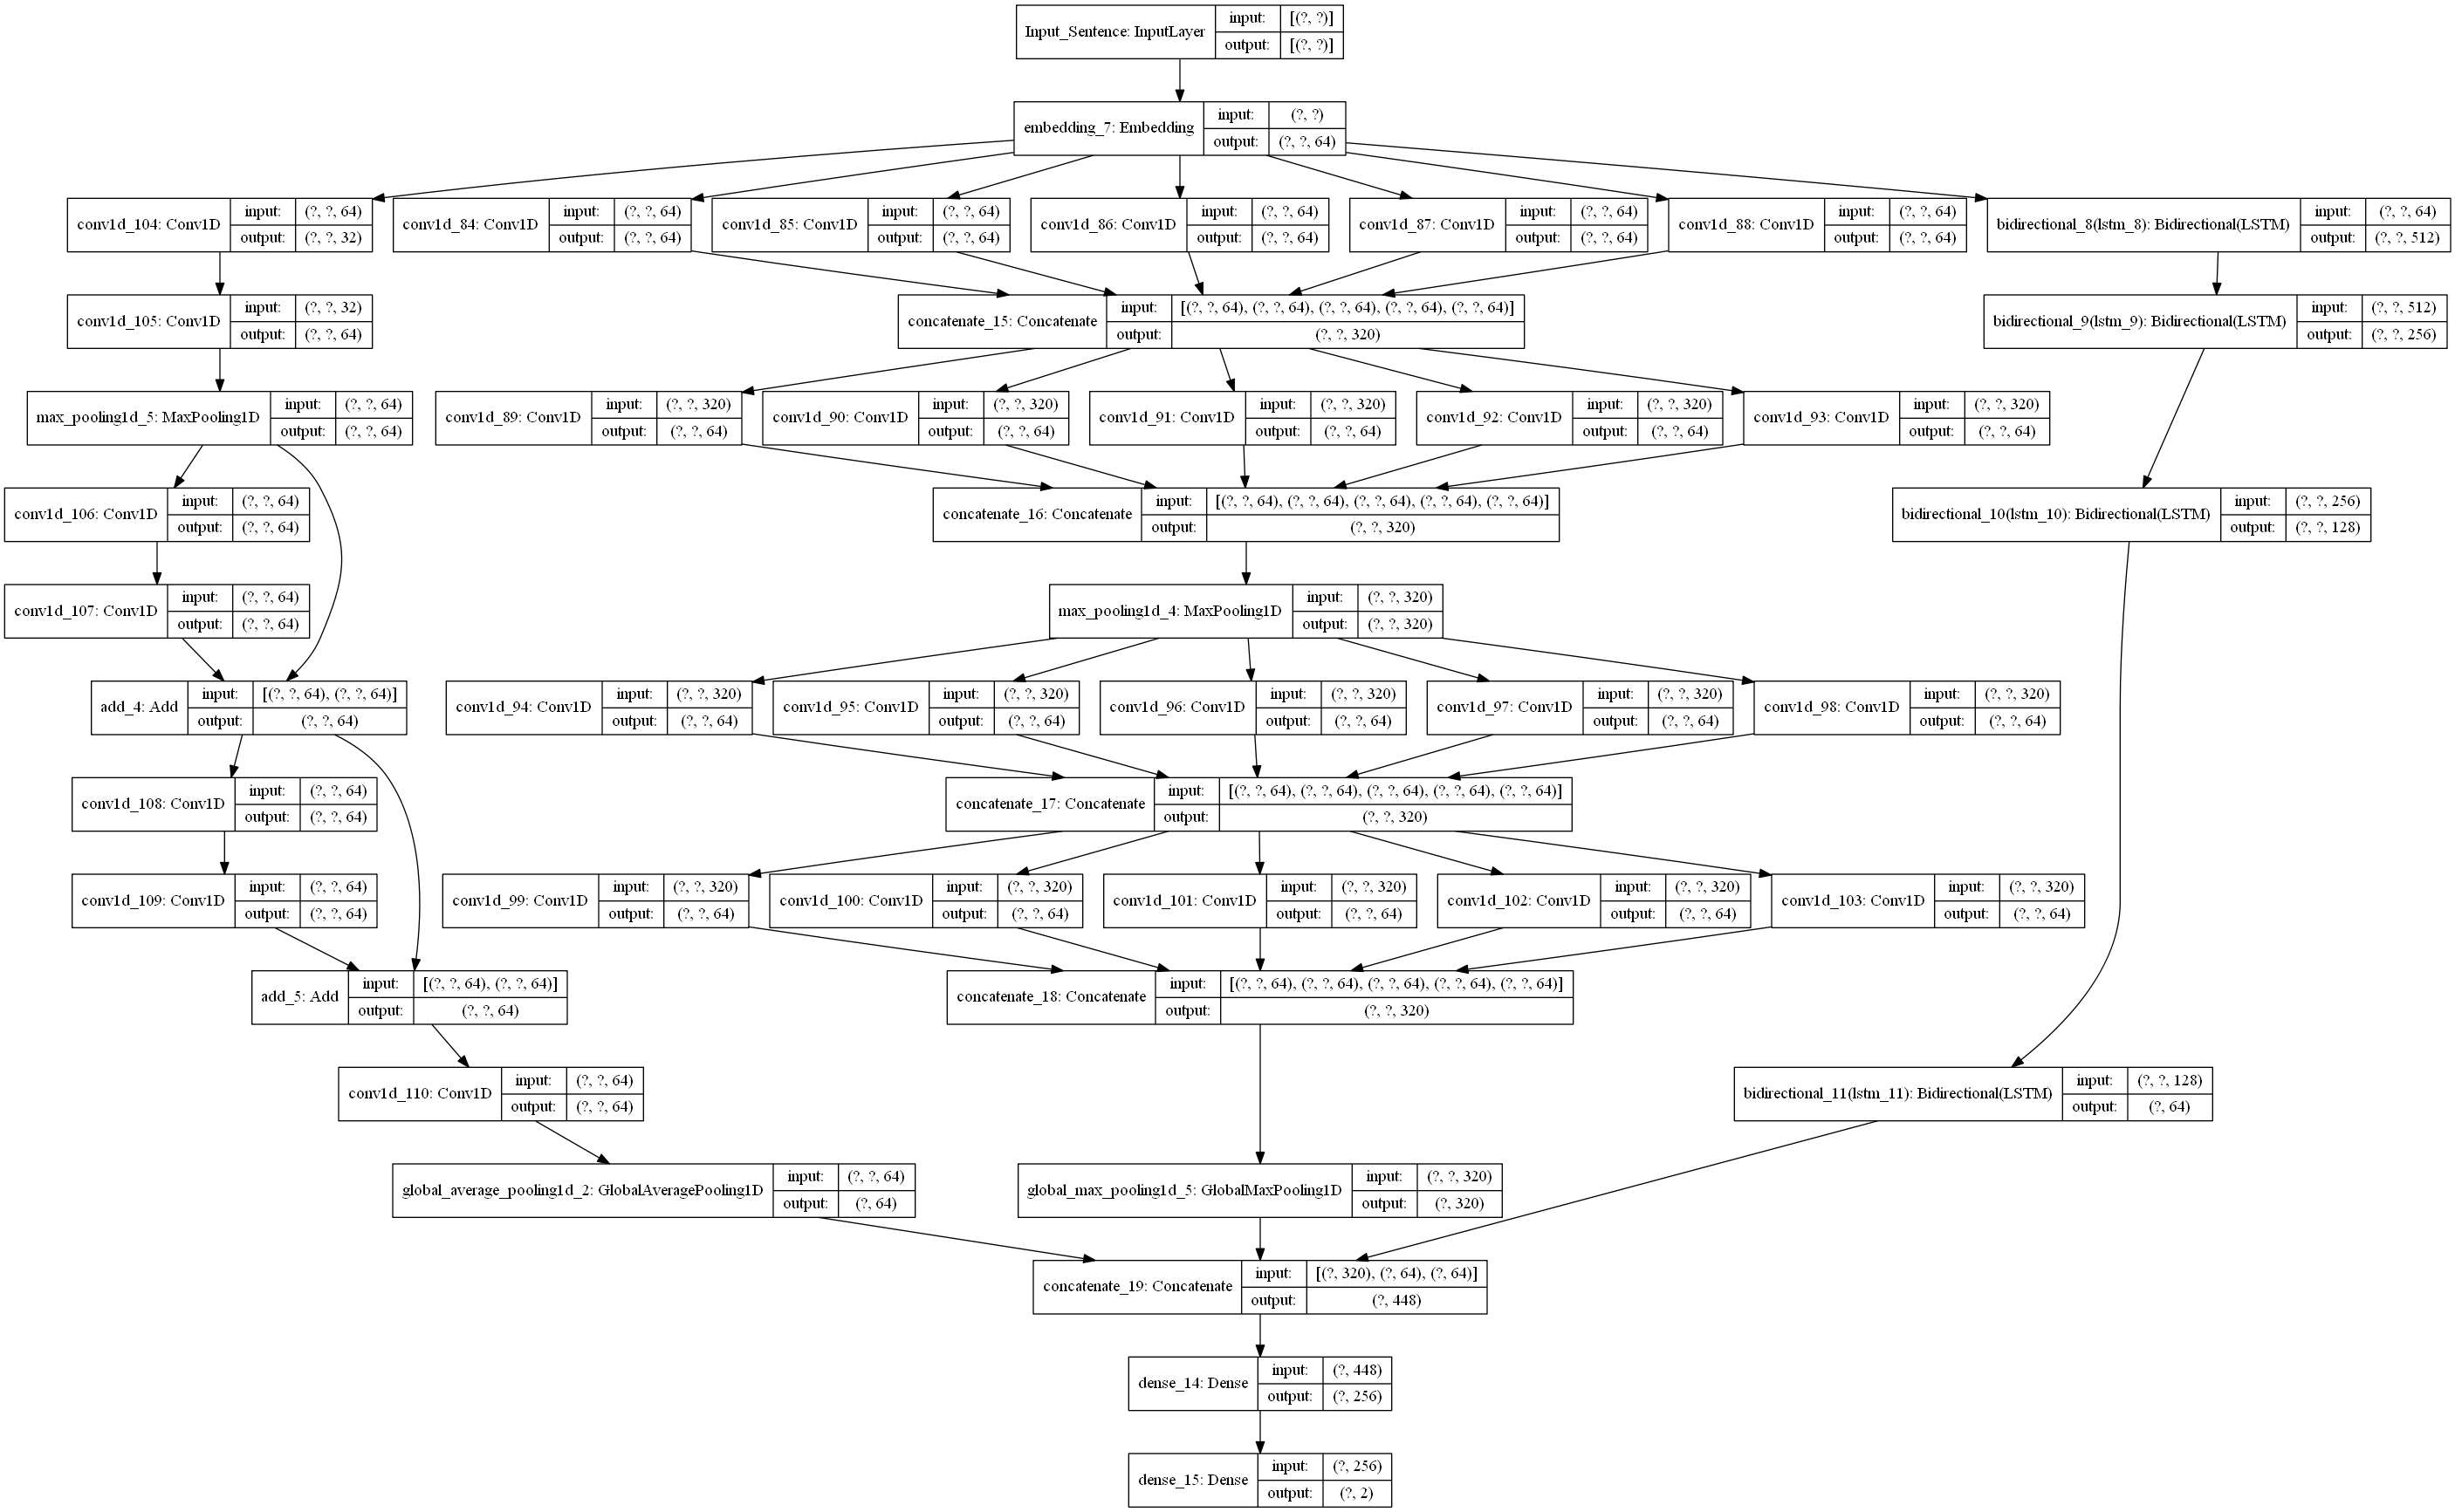

In [ ]:
keras.utils.plot_model(all3_v2_model,show_shapes= True,to_file="./model-image/all3-v2.png")

In [ ]:
all3_v2_model ,history_all3v2 = trainModel(all3_v2_model,'all3v2')

Epoch 1/15
32/32 [==============================] - 2170s 68s/step - loss: 0.7068 - accuracy: 0.6310 - val_loss: 0.3024 - val_accuracy: 0.8500
Epoch 2/15
32/32 [==============================] - 2158s 67s/step - loss: 0.3318 - accuracy: 0.9060 - val_loss: 0.2566 - val_accuracy: 0.9400
Epoch 3/15
32/32 [==============================] - 2263s 71s/step - loss: 0.6469 - accuracy: 0.8960 - val_loss: 0.2125 - val_accuracy: 0.9400
Epoch 4/15
26/32 [=======================>......] - ETA: 7:19 - loss: 0.1326 - accuracy: 0.9724

KeyboardInterrupt: 

## 2 Pair gnet,lstm

### V1

In [ ]:
def gnet_lstm_v1(input_embeddings):
    gnet = inseptionNetwork(input_embeddings)
    lstm = LSTMnetwork(input_embeddings)
    y = layers.concatenate([gnet,lstm])
    return y

In [ ]:
gnet_lstm_v1_model = generateModel(gnet_lstm_v1)

NameError: name 'inseptionNetwork' is not defined

In [ ]:
keras.utils.plot_model(gnet_lstm_v1_model,show_shapes= True,to_file="./model-image/gnet_lstm_v1.png")

In [ ]:
gnet_lstm_v1_model ,history_gnet_lstm_v1 = trainModel(gnet_lstm_v1_model,'gnet-lstm-v1')

### V2

In [ ]:
def gnet_lstm_v2(input_embeddings):
    gnet = inseptionNetwork2Layer(input_embeddings)
    lstm = LSTMnetwork(input_embeddings)
    y = layers.concatenate([gnet,lstm])
    return y

In [ ]:
gnet_lstm_v2_model = generateModel(gnet_lstm_v2)

In [ ]:
keras.utils.plot_model(gnet_lstm_v2_model,show_shapes= True,to_file="./model-image/gnet_lstm_v2.png")

In [ ]:
gnet_lstm_v2_model ,history_gnet_lstm_v2 = trainModel(gnet_lstm_v2_model,'gnet-lstm-v2')

## Resnet ,lstm

In [ ]:
def resnet_lstm(input_embeddings):
    resnet = resNet(input_embeddings)
    lstm = LSTMnetwork(input_embeddings)
    y = layers.concatenate([resnet,lstm])
    return y

In [ ]:
resnet_lstm_model = generateModel(resnet_lstm)

In [ ]:
keras.utils.plot_model(resnet_lstm_model,show_shapes= True,to_file="./model-image/resnet_lstm.png")

In [ ]:
resnet_lstm_model ,history_resnet_lstm = trainModel(resnet_lstm_model,'resnet-lstm')